# First steps

In this notebook we will discover few essentials ideas about model selection.
We will test one of the most basic models : the linear regression.
<p>
    In the fist notebook, a few correlation were discovered. We will know produce a simple model that will <em>automatically</em> learn how to predict the <code>revenue</code> of a client depending on known features (such as <code>price_first_item_purchased</code> or <code>pages_visited</code>)
</p>

In [3]:
#We import the usuals packages and the model from sklearn 
%pylab inline
import seaborn
from pylab import rcParams
rcParams['figure.figsize'] = 16, 4
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


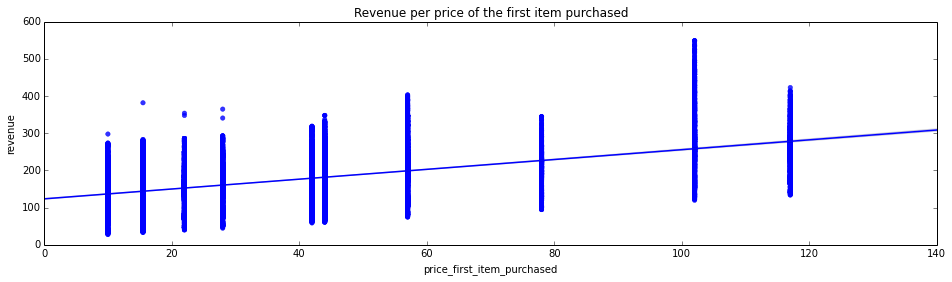

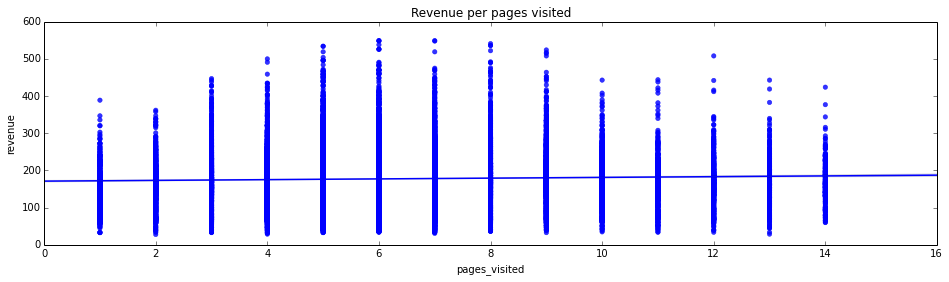

In [4]:
dataset = pd.read_csv("./customerLifetimeValue.csv", sep=";")
plt.title("Revenue per price of the first item purchased")
seaborn.regplot(dataset.price_first_item_purchased, dataset.revenue)
plt.show()
plt.title("Revenue per pages visited")
seaborn.regplot(dataset.pages_visited, dataset.revenue)

<p>
    Can we produce a model, i.e. a <em>function</em> that predicts the correct revenue class knowing the <code>price_first_item_pruchased</code> and the <code>pages_visited</code> features ?
</p>
<p>
    To make the probmel easyer, we will consider a <em>binary</em> version of it : instead of predicting the <code>revenue</code>, we will rather predict if the target is above or below a certain value, 175\$ in our case. Now our new target is not continuous anymore but binary : 0 if the revenue is lower then 175\$ and 1 if it's greater.
</p>
<p>
    To perform the prediction, we will use two features : <code>price_first_item_purchased</code> and <code>pages_visited</code>.
</p>

In [5]:
#We take the columns we need for our models and get the underlying matrix
X = dataset[["price_first_item_purchased", "pages_visited"]].values
#We binarize the target, all value greater than a given revenue will become positive (1), other negative(0)
Y = dataset["revenue"].values.copy()
Y[Y <= 175] = 0
Y[Y > 175] = 1

To estimate the model's precision, we need to test it on data the model didn't fit on. We will split our sample in two dataframes : test and train.

In [6]:
from sklearn.model_selection import train_test_split
#The left part of this line is known as the "multiple assignement". The right part is a function that will
#automatically split a data set into test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

<h3>Our first model</h3>
<p>
    Our frist model will be a <a href="https://www.statisticssolutions.com/what-is-logistic-regression/">Logistic Regression</a>. The only things we need to know now are that :
    <ul>
        <li>The model learns individual <em>coefficient</em> for each feature</li>
        <li>The higher is a coefficient, the stronger is the correlation between the feature and the probability of the sample to belong to the positive class</li>
        <li>A null coefficient, close to 0, means that their are no or few correlation between the feature and the probability of belonging to a class</li>
        <li>A strong negative coefficient will mean that their is a <em>negative</em> correlation between the feature and the probability : the higher is the value of the feature for a sample and the lower is the probability of beloging to the positive class (i.e. revenue > 175$\)</li>
    </ul>
</p>

In [9]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<p>
    Based on what was said before, we can now <em>interpret</em> the model's parameters. There are two of them :
    <ul>
        <li>The coefficient related to the feature <code>price_first_item_purchased</code></li>
        <li>The coefficient related to the feature <code>pages_visited</code></li>
        <li>A parameter called <em>intercept</em>. To know more about the role of this parameter, chek out <a href="https://en.wikipedia.org/wiki/Logistic_regression">this link</a>
    </ul>
</p>
The parameters of the models are displayed in the cell below. We can observe that both of them are positive, indicating a positive correlation between <code>price_first_item_purchased</code>, <code>pages_visited</code> and the probability of a positive target (revenue > 175\$)

In [11]:
model.coef_

array([[0.03574269, 0.02189533]])

One of the most important thing about the precision of a model is to choose a metric : a way to assess the performance of our model. Here we will chose the ROC metric, but a lot of other metrics exists.
<p>
    The AUC-ROC (area under the curve - Receiver operating characteristic) metric equals 1 when the models performs perfectly and 0 otherwise. Here, we can expect values above 0.65.
</p>
<p>
    It's a really common metric in classification problems. If you want to know more about it, check <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve">this link</a>
</p>


In [117]:
from sklearn.metrics import roc_auc_score
train_score = roc_auc_score(Y_train, model.predict(X_train))
test_score = roc_auc_score(Y_test, model.predict(X_test))
print("train score : %f, test score : %f"%(train_score, test_score))

train score : 0.675441, test score : 0.679527


<h3>K-Folding</h3>

<p>
    In order to reduce the <a href="https://en.wikipedia.org/wiki/Standard_deviation">standar-deviation</a> of the AUC score, we can make the test/train splits and the training process on several chunks of the whole dataset then average the results. This method is called K-folding or <em>cross-validation</em>. This way, the model - although retrained - will be tested on the whole data set thus reducing the standar-deviation of the AUC measure.
</p>
<img src="https://www.researchgate.net/profile/Kiret_Dhindsa/publication/323969239/figure/fig10/AS:607404244873216@1521827865007/The-K-fold-cross-validation-scheme-133-Each-of-the-K-partitions-is-used-as-a-test.ppm" />

In [63]:
from sklearn.model_selection import KFold
folds_maker = KFold(n_splits=10)
train_score = []
test_score = []
for train_index, test_index in folds_maker.split(X):
    X_train, y_train = X[train_index], Y[train_index]
    X_test, y_test = X[test_index], Y[test_index]
    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_score.append(roc_auc_score(y_train, model.predict(X_train)))
    test_score.append(roc_auc_score(y_test, model.predict(X_test)))
print("train score : %f, test score : %f"%(np.mean(train_score), np.mean(test_score)))

train score : 0.678185, test score : 0.677965


Since we train as many model as we have folds (10 folds in the cell above) this lengthens the training process.
Now its your turn to perfom a K-fold on a model on the following input features : <code>campain</code> and 
<code>since_birth_parsed_days</code>

<em>
    You can follow the same steps as we did above : create the correct X variable and perform the K-fold itself since the Y is the same.
</em>